# Refine Woodward rules for alpha,beta substituted Carbonyl compounds


In [24]:
import sys, os
import pandas as pd
import numpy as np

from rdkit import Chem

sys.path.append('../../Woodward_Fieser_Rules-main/src/')
import chromopredict as cp

In [25]:
df = pd.read_csv('ds_enones_b3lyp_woodward_1state.csv')
df_all = df[['moltype', 'smiles', 'solvent', 'nm_b3lyp']]

df_all.head(n=5)

,moltype,smiles,solvent,nm_b3lyp
0,aldehyde,O=C/C(C)=C(C)\OC,NaN,258.6
1,aldehyde,O=C/C(C)=C(C)\Cl,NaN,256.8
2,aldehyde,O=C/C(C)=C(C)\Br,NaN,269.1
3,aldehyde,O=C/C(C)=C(C)\O,NaN,247.0
4,aldehyde,O=C/C(C)=C/C,NaN,239.6


In [26]:
df_all.count()

moltype     720
smiles      720
solvent       0
nm_b3lyp    720
dtype: int64

In [27]:
from rdkit import Chem
from rdkit.Chem import rdchem

def detect_cis_trans(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    for bond in mol.GetBonds():
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            stereo = bond.GetStereo()
            if stereo == rdchem.BondStereo.STEREOZ:
                return 'cis'
            elif stereo == rdchem.BondStereo.STEREOE:
                return 'trans'
    return 'no_stereo'

# Apply to create a mask
df_all = df_all.copy()
df_all['stereo_type'] = df_all['smiles'].apply(detect_cis_trans)

df_all.head(n=3)

,moltype,smiles,solvent,nm_b3lyp,stereo_type
0,aldehyde,O=C/C(C)=C(C)\OC,NaN,258.6,cis
1,aldehyde,O=C/C(C)=C(C)\Cl,NaN,256.8,cis
2,aldehyde,O=C/C(C)=C(C)\Br,NaN,269.1,cis


In [28]:
def add_wf_predict(df):

    nm_wf = []
    img_wf = []
    contrib_wf = []

    nm_wfe = []
    img_wfe = []
    contrib_wfe = []
    
    for _, row in df.iterrows():
        smi = row['smiles']
        solv = row['solvent']
        
        # woodward
        nm, d_contrib, img = cp.predict(smi, solvent=None, verbose=True, draw=False, chromlib='woodward')
        nm_wf.append(nm)
        contrib_wf.append(d_contrib)
        img_wf.append(img)
        
        # woodward extended
        nm, d_contrib, img = cp.predict(smi, solvent=None, verbose=True, draw=False, chromlib='woodward_extended')
        nm_wfe.append(nm)
        contrib_wfe.append(d_contrib)
        img_wfe.append(img)
        
        
    df['nm_wf'] = nm_wf
    df['nm_wfe'] = nm_wfe
    
    df['contrib_wf'] = contrib_wf
    df['contrib_wfe'] = contrib_wfe
    
    df['img_wf'] = img_wf
    df['img_wfe'] = img_wfe


In [29]:
add_wf_predict(df_all)


In [30]:
df_tmp = df_all[['moltype', 'smiles', 'solvent', 'stereo_type', 'nm_b3lyp', 'nm_wf', 'contrib_wf']]

contrib_expanded = df_tmp['contrib_wf'].apply(pd.Series)
df_wf_all = pd.concat([df_tmp.drop(columns='contrib_wf'), contrib_expanded], axis=1)
df_wf_all['Nsub'] = df_wf_all.apply(
    lambda row: len(row['alpha_all']) + len(row['beta_all']),
    axis=1
)

df_wf_all.head(n=5)

,moltype,smiles,solvent,stereo_type,nm_b3lyp,nm_wf,base,factor,alpha,alpha_all,beta,beta_all,gamma,gamma_all,higher,higher_all,exo,solvent,Nsub
0,aldehyde,O=C/C(C)=C(C)\OC,NaN,cis,258.6,250,210,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",alkoxy,"[{'pattern': 'alkoxy', 'value': 30, 'sub_type'...",H,[],H,[],0,0,3
1,aldehyde,O=C/C(C)=C(C)\Cl,NaN,cis,256.8,232,210,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",alkyl,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,0,3
2,aldehyde,O=C/C(C)=C(C)\Br,NaN,cis,269.1,250,210,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",bromo,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,0,3
3,aldehyde,O=C/C(C)=C(C)\O,NaN,cis,247.0,250,210,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",hydroxy,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,0,3
4,aldehyde,O=C/C(C)=C/C,NaN,trans,239.6,232,210,0,alkyl,"[{'pattern': 'alkyl', 'value': 10, 'sub_type':...",alkyl,"[{'pattern': 'alkyl', 'value': 12, 'sub_type':...",H,[],H,[],0,0,2


In [48]:
df_4fit_wf = df_wf_all[['moltype', 'smiles', 'stereo_type', 'nm_b3lyp', 'nm_wf', 'alpha', 'beta', 'Nsub']]

df_4fit_wf = df_4fit_wf.copy()
df_4fit_wf['base'] = df_4fit_wf['moltype'] + '_' + df_4fit_wf['stereo_type']

df_4fit_wf.head(n=5)

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,Nsub,base
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,alkyl,alkoxy,3,aldehyde_cis
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,alkyl,alkyl,3,aldehyde_cis
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,alkyl,bromo,3,aldehyde_cis
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,alkyl,hydroxy,3,aldehyde_cis
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,2,aldehyde_trans


In [49]:
# One-hot encode features
X_base = pd.get_dummies(df_4fit_wf['base'], prefix='base') #base
X_alpha = pd.get_dummies(df_4fit_wf['alpha'], prefix='alpha')
X_beta = pd.get_dummies(df_4fit_wf['beta'], prefix='beta')

# Combine into one feature matrix
X = pd.concat([X_base, X_alpha, X_beta], axis=1)
y = df_4fit_wf['nm_b3lyp']

feature_names = X.columns.tolist()

In [50]:
feature_names

['base_acid_cis',
 'base_acid_no_stereo',
 'base_acid_trans',
 'base_aldehyde_cis',
 'base_aldehyde_no_stereo',
 'base_aldehyde_trans',
 'base_cyclohexenone_no_stereo',
 'base_cyclopentenone_no_stereo',
 'base_ketone_cis',
 'base_ketone_no_stereo',
 'base_ketone_trans',
 'alpha_H',
 'alpha_alkoxy',
 'alpha_alkyl',
 'alpha_bromo',
 'alpha_chloro',
 'alpha_hydroxy',
 'beta_H',
 'beta_alkoxy',
 'beta_alkyl',
 'beta_bromo',
 'beta_chloro',
 'beta_hydroxy']

In [52]:
initial_guesses = {
    # Base values (from original Woodward rules)
    #'base_acid': 194,
    #'base_aldehyde': 216,
    #'base_ketone': 212,
    #'base_cyclohexenone': 202,
    #'base_cyclopentenone': 290,
    
    'base_acid_cis': 195,
    'base_acid_no_stereo': 195,
    'base_acid_trans': 195,
    'base_aldehyde_cis': 210,
    'base_aldehyde_no_stereo': 210,
    'base_aldehyde_trans': 210,
    'base_ketone_cis': 215,
    'base_ketone_no_stereo': 215,
    'base_ketone_trans': 215,

    'base_cyclohexenone_no_stereo': 206,
    'base_cyclopentenone_no_stereo': 191,
    
    # Alpha substituent increments (default = 0, unless known)
    'alpha_H': 0,
    'alpha_alkoxy': 35,
    'alpha_alkyl': 10,
    'alpha_bromo': 25,
    'alpha_chloro': 15,
    'alpha_hydroxy': 35,
    
    # Beta substituent increments (usually less than alpha)
    'beta_H': 0,
    'beta_alkoxy': 30,
    'beta_alkyl': 12,
    'beta_bromo': 30,
    'beta_chloro': 12,
    'beta_hydroxy': 30
}

x0 = np.array([initial_guesses.get(f, 0) for f in feature_names])
x0

array([195, 195, 195, 210, 210, 210, 206, 191, 215, 215, 215,   0,  35,
        10,  25,  15,  35,   0,  30,  12,  30,  12,  30])

### Fit Woodward parameters to DFT data

In [53]:
from scipy.optimize import dual_annealing
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define Loss Function
def integer_loss_fn(coefs):
    coefs_int = np.round(coefs)
    pred = X @ coefs_int
    return mean_absolute_error(pred, y) #np.sum(np.abs(pred - y))

# Define bounds
bounds = []
for f in feature_names:
    if f in ['alpha_H', 'beta_H']:
        bounds.append((0, 0.001))
    elif 'base' in f:
        bounds.append((150, 300))
    else:
        bounds.append((1, 50))

# Run optimization multiple times and keep the best result
n_runs = 100
best_loss = float('inf')
best_coefs = None

for i in range(n_runs):
    result = dual_annealing(integer_loss_fn, bounds)
    rounded = np.round(result.x).astype(int)
    loss = integer_loss_fn(rounded)
    
    if loss < best_loss:
        best_loss = loss
        best_coefs = rounded

    print('Iteration: '+str(i)+', MAE: '+str(loss))
    
# Convert best coefficients to pandas Series
fitted_series_best = pd.Series(best_coefs, index=feature_names)

print("Best loss:", best_loss)
print("Best coefficients:")
print(fitted_series_best)


Iteration: 0, MAE: 7.950972222222222
Iteration: 1, MAE: 7.978750000000001
Iteration: 2, MAE: 7.992361111111111
Iteration: 3, MAE: 8.083194444444445
Iteration: 4, MAE: 7.943194444444444
Iteration: 5, MAE: 8.012916666666666
Iteration: 6, MAE: 7.941527777777779
Iteration: 7, MAE: 7.9390277777777785
Iteration: 8, MAE: 7.942361111111111
Iteration: 9, MAE: 8.037638888888889
Iteration: 10, MAE: 7.94125
Iteration: 11, MAE: 7.941527777777779
Iteration: 12, MAE: 8.001805555555555
Iteration: 13, MAE: 8.058472222222223
Iteration: 14, MAE: 8.025694444444444
Iteration: 15, MAE: 8.068194444444444
Iteration: 16, MAE: 7.942361111111111
Iteration: 17, MAE: 7.949861111111111
Iteration: 18, MAE: 8.00013888888889
Iteration: 19, MAE: 7.942361111111111
Iteration: 20, MAE: 7.941527777777779
Iteration: 21, MAE: 7.960972222222222
Iteration: 22, MAE: 7.942361111111111
Iteration: 23, MAE: 7.964305555555555
Iteration: 24, MAE: 7.941527777777777
Iteration: 25, MAE: 7.990416666666666
Iteration: 26, MAE: 7.9923611111

In [54]:
fitted_series = fitted_series_best
fitted_series

base_acid_cis                    197
base_acid_no_stereo              197
base_acid_trans                  198
base_aldehyde_cis                219
base_aldehyde_no_stereo          219
base_aldehyde_trans              221
base_cyclohexenone_no_stereo     208
base_cyclopentenone_no_stereo    193
base_ketone_cis                  211
base_ketone_no_stereo            215
base_ketone_trans                214
alpha_H                            0
alpha_alkoxy                      28
alpha_alkyl                       10
alpha_bromo                       38
alpha_chloro                      27
alpha_hydroxy                     38
beta_H                             0
beta_alkoxy                       21
beta_alkyl                        17
beta_bromo                        32
beta_chloro                       21
beta_hydroxy                      13
dtype: int64

In [59]:
#acids
int((197+197+198)/3)

197

In [60]:
#aldehydes
int((219+219+221)/3)

219

In [61]:
#ketones
int((211+215+214)/3)

213

### Woodward vs. DFT-refined Woodward

Add updated list of values to dataset and compare original woodward predictiosn with refined values

In [55]:
def get_value(row, col_prefix):
    key = f"{col_prefix}_{row[col_prefix]}"
    #print(key)
    return fitted_series.get(key, 0)

In [56]:
df_4fit_wf['alpha_val'] = df_4fit_wf.apply(lambda row: get_value(row, 'alpha'), axis=1)
df_4fit_wf['beta_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'beta'), axis=1)
df_4fit_wf['base_val']  = df_4fit_wf.apply(lambda row: get_value(row, 'base'), axis=1)

df_4fit_wf

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,Nsub,base,alpha_val,beta_val,base_val
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,alkyl,alkoxy,3,aldehyde_cis,10,21,219
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,alkyl,alkyl,3,aldehyde_cis,10,17,219
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,alkyl,bromo,3,aldehyde_cis,10,32,219
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,alkyl,hydroxy,3,aldehyde_cis,10,13,219
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,2,aldehyde_trans,10,17,221
...,...,...,...,...,...,...,...,...,...,...,...,...
715,cyclohexenone,C1(=O)C=C(Br)CCC1,no_stereo,241.2,245,H,bromo,2,cyclohexenone_no_stereo,0,32,208
716,cyclohexenone,C1(=O)C(Br)=C(Br)CCC1,no_stereo,272.5,270,bromo,bromo,3,cyclohexenone_no_stereo,38,32,208
717,cyclohexenone,C1(=O)C(Cl)=CCCC1,no_stereo,250.6,242,chloro,alkyl,2,cyclohexenone_no_stereo,27,17,208
718,cyclohexenone,C1(=O)C=C(Cl)CCC1,no_stereo,228.8,227,H,alkyl,2,cyclohexenone_no_stereo,0,17,208


In [57]:
df_4fit_wf['nm_wf_refine'] = df_4fit_wf['alpha_val'] + df_4fit_wf['beta_val'] + df_4fit_wf['base_val']
df_4fit_wf.head(n=5)

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,Nsub,base,alpha_val,beta_val,base_val,nm_wf_refine
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,alkyl,alkoxy,3,aldehyde_cis,10,21,219,250
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,alkyl,alkyl,3,aldehyde_cis,10,17,219,246
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,alkyl,bromo,3,aldehyde_cis,10,32,219,261
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,alkyl,hydroxy,3,aldehyde_cis,10,13,219,242
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,2,aldehyde_trans,10,17,221,248


In [58]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df_4fit_wf['nm_b3lyp'], df_4fit_wf['nm_wf_refine'])
mae_ori = mean_absolute_error(df_4fit_wf['nm_b3lyp'], df_4fit_wf['nm_wf'])

mae, mae_ori

(7.93875, 13.306805555555554)

In [43]:
#rdkit.Chem.MolFromSmiles('CC(C#C)OC=1C=C2C=CC(OC2=CC1)=O')

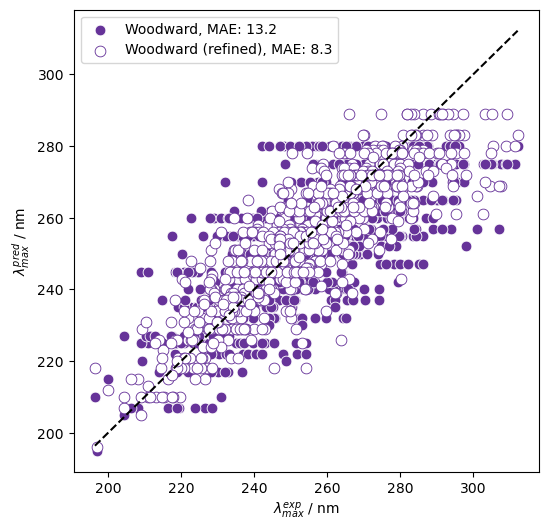

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    marker='o',
    color='rebeccapurple',
    s=60,
    label='Woodward, MAE: 13.2'
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    marker='o',
    facecolors='white',
    edgecolor='rebeccapurple',
    s=60,
    label='Woodward (refined), MAE: 8.3'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')

plt.xlabel('$\lambda_{max}^{exp}$ / nm')
plt.ylabel('$\lambda_{max}^{pred}$ / nm')

#plt.show()
plt.savefig('WF_vs_WFR_enones.png')

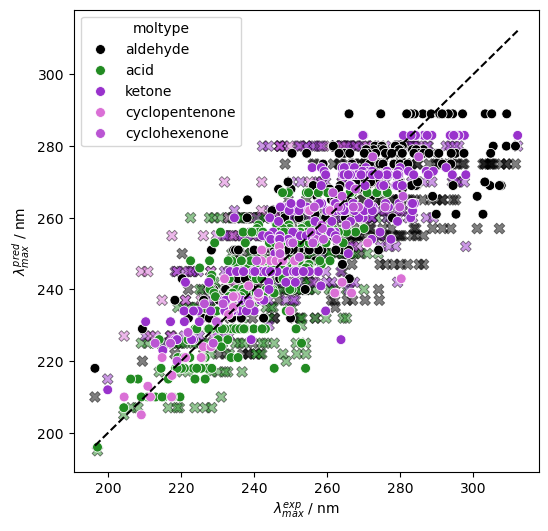

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    hue='moltype',
    palette={'aldehyde': 'black', 'acid': 'forestgreen', 'ketone': 'darkorchid', 'cyclohexenone': 'mediumorchid', 'cyclopentenone': 'orchid'},
    edgecolor='black',
    alpha=0.5,
    marker='X',
    #style='o', #'stereo_mismatch',
    s=60,
    legend=None, #{'Woodward', 'Woodward (stereo-mismatch)'}
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    hue='moltype',
    palette={'aldehyde': 'black', 'acid': 'forestgreen', 'ketone': 'darkorchid', 'cyclohexenone': 'mediumorchid', 'cyclopentenone': 'orchid'},
    edgecolor='white',
    marker='o',
    s=50,
    #legend=None, #'Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')

plt.xlabel('$\lambda_{max}^{exp}$ / nm')
plt.ylabel('$\lambda_{max}^{pred}$ / nm')

plt.savefig('WF_vs_WFR_enones_color-class.png')

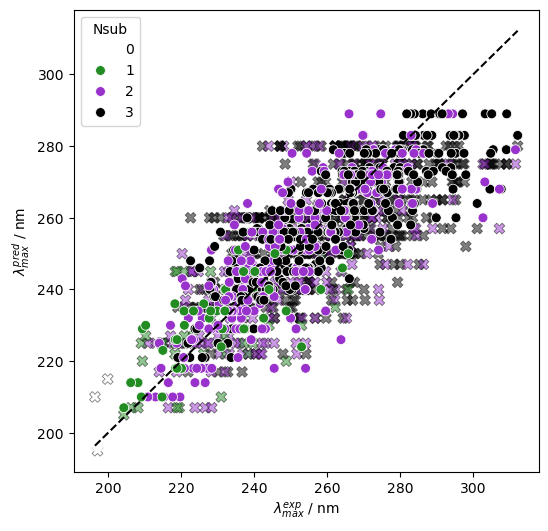

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    hue='Nsub',
    palette={0: 'white', 1: 'forestgreen', 2: 'darkorchid', 3: 'black'},
    edgecolor='black',
    alpha=0.5,
    marker='X',
    #style='o', #'stereo_mismatch',
    s=60,
    legend=None, #{'Woodward', 'Woodward (stereo-mismatch)'}
)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    hue='Nsub',
    palette={0: 'white', 1: 'forestgreen', 2: 'darkorchid', 3: 'black'},
    edgecolor='white',
    marker='o',
    s=50,
    #legend=None, #'Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')

plt.xlabel('$\lambda_{max}^{exp}$ / nm')
plt.ylabel('$\lambda_{max}^{pred}$ / nm')

plt.savefig('WF_vs_WFR_enones_count-sub.png')

In [30]:
df_4fit_wf

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,Nsub,base,alpha_val,beta_val,base_val,nm_wf_refine
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,alkyl,alkoxy,3,aldehyde,9,19,223,251
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,alkyl,alkyl,3,aldehyde,9,14,223,246
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,alkyl,bromo,3,aldehyde,9,30,223,262
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,alkyl,hydroxy,3,aldehyde,9,12,223,244
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,2,aldehyde,9,14,223,246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,ketone,O=C(C)/C=C\OC,cis,228.1,245,H,alkoxy,1,ketone,0,19,217,236
644,ketone,O=C(C)/C=C\Cl,cis,223.4,227,H,chloro,1,ketone,0,19,217,236
645,ketone,O=C(C)/C=C\Br,cis,237.1,245,H,bromo,1,ketone,0,30,217,247
646,ketone,O=C(C)/C=C\O,cis,218.9,245,H,hydroxy,1,ketone,0,12,217,229


In [32]:
#df_2save_wf = df_4fit_wf[['smiles', 'nm_b3lyp', 'nm_wf', 'nm_wfe', 'nm_wf_refine']]
#df_2save_wf.to_csv("smiles_absmax.csv", index=False)

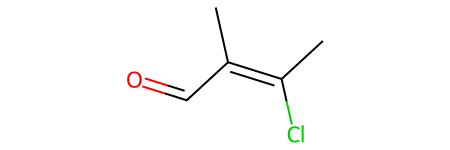

In [33]:
import rdkit

rdkit.Chem.MolFromSmiles('O=C/C(C)=C(C)\Cl')

In [34]:
def woodward_stereo_label_conditional(alpha, beta, current_stereo):
    HIGHER_PRIO = ['bromo', 'chloro', 'alkoxy', 'hydroxy']
    
    if current_stereo not in ['cis', 'trans']:
        # Leave unchanged if already 'no_stereo' or anything else
        return current_stereo
    
    # Now apply Woodward rules only if current stereo is cis or trans
    if alpha in HIGHER_PRIO and beta != 'H':
        return 'trans'
    elif alpha in HIGHER_PRIO and beta == 'H':
        return 'no_stereo'
    elif alpha in ['alkyl', 'H'] and beta != 'H':
        return 'cis'
    elif alpha == 'H' and beta == 'H':
        return 'no_stereo'
    else:
        return current_stereo  # fallback, keep current

def woodward_stereo_label_trans(alpha, beta, current_stereo):
    
    return 'trans'


In [35]:
#df_smi = df_4fit_wf[['smiles', 'stereo_type']]
df_4fit_wf['wf_stereo_label'] = df_4fit_wf.apply(
    lambda row: woodward_stereo_label_conditional(row['alpha'], row['beta'], row['stereo_type']),axis=1
)


df_4fit_wf['stereo_mismatch'] = (df_4fit_wf['stereo_type'] != df_4fit_wf['wf_stereo_label']).astype(int)

df_4fit_wf

,moltype,smiles,stereo_type,nm_b3lyp,nm_wf,alpha,beta,Nsub,base,alpha_val,beta_val,base_val,nm_wf_refine,wf_stereo_label,stereo_mismatch
0,aldehyde,O=C/C(C)=C(C)\OC,cis,258.6,250,alkyl,alkoxy,3,aldehyde,9,19,223,251,cis,0
1,aldehyde,O=C/C(C)=C(C)\Cl,cis,256.8,232,alkyl,alkyl,3,aldehyde,9,14,223,246,cis,0
2,aldehyde,O=C/C(C)=C(C)\Br,cis,269.1,250,alkyl,bromo,3,aldehyde,9,30,223,262,cis,0
3,aldehyde,O=C/C(C)=C(C)\O,cis,247.0,250,alkyl,hydroxy,3,aldehyde,9,12,223,244,cis,0
4,aldehyde,O=C/C(C)=C/C,trans,239.6,232,alkyl,alkyl,2,aldehyde,9,14,223,246,cis,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,ketone,O=C(C)/C=C\OC,cis,228.1,245,H,alkoxy,1,ketone,0,19,217,236,cis,0
644,ketone,O=C(C)/C=C\Cl,cis,223.4,227,H,chloro,1,ketone,0,19,217,236,cis,0
645,ketone,O=C(C)/C=C\Br,cis,237.1,245,H,bromo,1,ketone,0,30,217,247,cis,0
646,ketone,O=C(C)/C=C\O,cis,218.9,245,H,hydroxy,1,ketone,0,12,217,229,cis,0


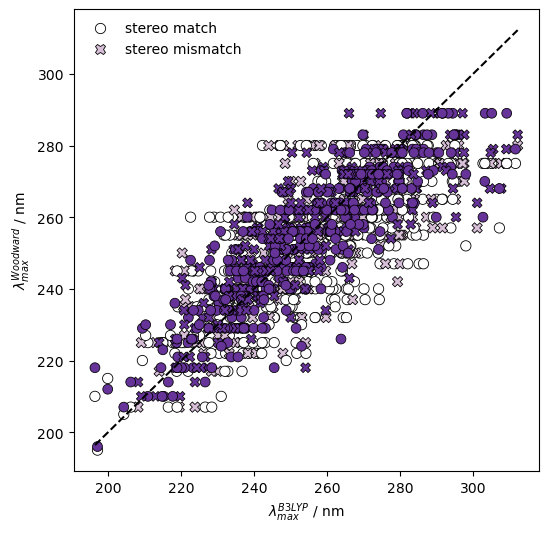

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Create the plot
ax = sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf',
    hue='stereo_mismatch',
    palette={0: 'white', 1: 'thistle'},
    edgecolor='black',
    style='stereo_mismatch',
    #marker='X',
    s=55,
)

# Customize legend labels
new_labels = ['stereo match', 'stereo mismatch']
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=new_labels, title=None, frameon=False)

# Plot hollow circles for 'nm_wfe'
sns.scatterplot(
    data=df_4fit_wf,
    x='nm_b3lyp',
    y='nm_wf_refine',
    #hue='stereo_mismatch',
    #palette={0: 'black', 1: 'purple'},
    edgecolor='black',
    facecolor='rebeccapurple',
    style='stereo_mismatch',
    #marker='o',
    s=50,
    legend=None, #'Woodward (refined)'
)

# Add identity line for reference
plt.plot([df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         [df_4fit_wf['nm_b3lyp'].min(), df_4fit_wf['nm_b3lyp'].max()],
         'k--', label='y = x')


plt.xlabel('$\lambda_{max}^{B3LYP}$ / nm')
plt.ylabel('$\lambda_{max}^{Woodward}$ / nm')

plt.savefig('WF_vs_WFR_enones_stereo.png')

In [ ]:
sns.scatterplot(
    data=df_4fit_wf,
    x='stereo_type',
    y='nm_wf_refine',
    #hue='stereo_mismatch',
    #palette={0: 'black', 1: 'purple'},
    edgecolor='black',
    facecolor='rebeccapurple',
    style='stereo_mismatch',
    #marker='o',
    s=50,
    legend=None, #'Woodward (refined)'
)



In [ ]:
rdkit.Chem.MolFromSmiles('O=CC(OC)=C(OC)OC')

In [ ]:
rdkit.Chem.MolFromSmiles('C/C=C(/C)C=O')

In [ ]:
detect_cis_trans('C/C=C(\C)C=O')